735 980


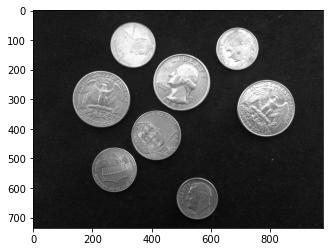

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2

image = cv2.imread('coins.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
height, width = gray.shape
print(height, width)

plt.imshow(gray, cmap='gray')
plt.show()

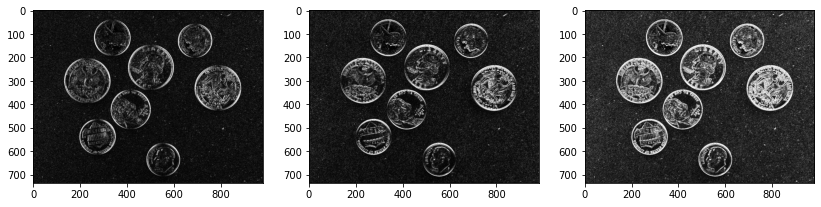

In [3]:
img_sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
img_sobel_x = cv2.convertScaleAbs(img_sobel_x)

img_sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
img_sobel_y = cv2.convertScaleAbs(img_sobel_y)


img_sobel = cv2.addWeighted(img_sobel_x, 1, img_sobel_y, 1, 0);

plt.figure(figsize=(14,7))
plt.subplot(131)
plt.imshow(img_sobel_x, cmap='gray')

plt.subplot(132)
plt.imshow(img_sobel_y, cmap='gray')

plt.subplot(133)
plt.imshow(img_sobel, cmap='gray')

plt.show()

245.0


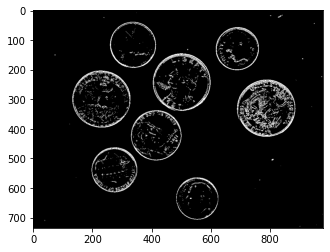

In [4]:
threshold, binary_img = cv2.threshold(img_sobel, 245, 255, cv2.THRESH_BINARY)

print(threshold)
plt.imshow(binary_img, cmap='gray')
plt.show()

### 아래 함수는 OpenCV 라이브러리를 사용하지 않고 구현

In [5]:
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage

def Hough_Circles(origin_img, rmin, rmax): # 함수에 필요한 변수도 스스로 정하고 이에 따른 함수를 작성하시오

  # Hough_Circle 함수에서 사용할 절대값을 취하지 않은 Sobel X, Y 각각과 Gradient 방향 계산을 위해 작성한 함수
  def SobelEdge(img, threshold): # Gradient를 구하기 위해 Sobel Edge Detector 구현
    X_Sobel = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    Y_Sobel = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

    # X, Y 축에 대해 소벨 연산자 대입
    x_sobel_img = np.zeros((height, width))
    y_sobel_img = np.zeros((height, width))
    for i in range(1, height-1):
      for j in range(1, width-1):
        pixel_x = 0
        pixel_y = 0
        for y in range(X_Sobel.shape[0]):
          for x in range(X_Sobel.shape[1]):
            if i+y-1 >= 0 and i+y-1 < height and j+x-1 >= 0 and j+x-1 < width:
              pixel_x += img[i+y-1][j+x-1] * X_Sobel[y][x]
              pixel_y += img[i+y-1][j+x-1] * Y_Sobel[y][x]
        x_sobel_img[i][j] = pixel_x
        y_sobel_img[i][j] = pixel_y
    
    # # Threshold를 원이 잘 검출되는 일정 수준으로 설정
    sobel_img = np.zeros((height, width))
    sobel_img = abs(x_sobel_img) + abs(y_sobel_img)
    for i in range(height):
      for j in range(width):
        if sobel_img[i][j] >= threshold:
          sobel_img[i][j] = 255
        else:
          sobel_img[i][j] = 0

    return x_sobel_img, y_sobel_img, sobel_img

    
  # SobelEdge는 입력받은 원본 영상에 대해 X, Y축 각각에 대한 Sobel Masking 영상과 이진화한 영상 반환
  x_sobel, y_sobel, sobel_img = SobelEdge(origin_img, 245)
  grad = np.arctan2(y_sobel, x_sobel) # 각 Pixel에 대해 Gradient 방향을 구함

  # voting을 위한 동일 사이즈의 빈 영상 생성
  votes = np.zeros((height, width))

  # 입력받은 반지름의 최솟값, 최댓값을 이용해 Voting
  for i in range(height):
    for j in range(width):
      if sobel_img[i][j] != 0:
        for r in range(rmin, rmax):
          yp = int(i+r*np.sin(grad[i][j]))
          xp = int(j+r*np.cos(grad[i][j]))
          if yp >= 0 and yp < height and xp >= 0 and xp < width:
            votes[yp][xp] += 1

  # 특정 위치에 대해 얼만큼의 범위를 한 점으로 계산할지와 임계값
  neighborhood_size = 40
  threshold = 55

  data_max = filters.maximum_filter(votes, neighborhood_size)
  maxima = (votes == data_max)

  data_min = filters.minimum_filter(votes, neighborhood_size)
  diff = ((data_max - data_min) > threshold)
  maxima[diff == 0] = 0

  labeled, num_objects = ndimage.label(maxima)
  slices = ndimage.find_objects(labeled)

  # threshold를 넘어 voting이 된 좌표를 원의 중심으로 저장
  x, y = [], []
  for dy,dx in slices:
      x_center = (dx.start + dx.stop - 1)/2
      x.append(x_center)
      y_center = (dy.start + dy.stop - 1)/2    
      y.append(y_center)

  # Voting 이미지 출력
  plt.imshow(votes)
  plt.show()

  # 원의 중심을 기준으로 가장 적합한 반지름(r)을 계산
  radius = []
  for xt, yt in zip(x, y):
    matched = 0
    match_r = 0
    for r in range(rmin, rmax):
      tmp = 0
      for p in range(1, 21):
        xpp = int(xt-r*np.cos(p/10 * np.pi))
        ypp = int(yt-r*np.sin(p/10 * np.pi))
        if xpp >= 0 and xpp < width and ypp >= 0 and ypp < height:
          if sobel_img[ypp][xpp] == 255:
            tmp += 1
      if tmp > matched:
        matched = tmp
        match_r = r
    radius.append(match_r)
      
  # x, y : 검출한 원의 중심의 좌표
  # radius : 검출한 원의 반지름
  return x, y, radius

### 아래 함수는 Hough Circle를 시각적으로 표현

In [6]:
import matplotlib.patches as patches

# img : 출력할 원본 영상, 소벨 마스킹하기 위한 영상
# rmin, rmax : 검출할 원의 최소, 최대 반지름
def display_Circles(origin_img, rmin, rmax): # 함수에 필요한 변수도 스스로 정하고 이에 따른 함수를 작성하시오
  x, y, r = Hough_Circles(origin_img, rmin, rmax)
  
  figure, axes = plt.subplots(1)
  axes.imshow(origin_img, cmap='gray')  # 원본 영상 출력
  plt.scatter(x, y, c='red')            # 원의 중심을 좌표상에 출력
  for item in zip(x, y, r):             # 원의 중심을 기준으로 해당하는 반지름의 원을 출력
    c = patches.Circle((int(item[0]), int(item[1])), radius=item[2], color='r', fill=False)
    axes.add_patch(c)
  plt.show()

### 주어진 동전을 읽고 결과를 출력하는 과정(함수 호출)

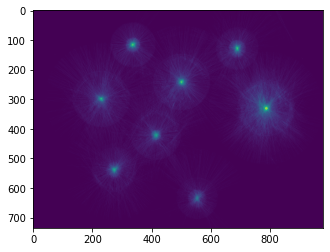

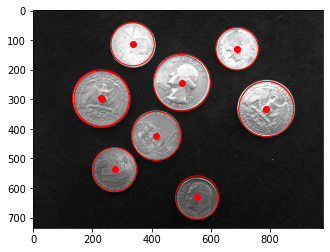

In [7]:
# 첫 번째 영상 : 원의 중점을 찾기 위해 사용한 Voting 이미지
# 두 번째 영상 : 추출한 원의 중점과 반지름을 기준으로 Gray 영상에 반영
display_Circles(gray, 1, 100)